## Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import io
from bitstring import BitArray

### Logarithmic Companding

#### $\mu$-law

$$c_\mu (|x|) = \frac{\log_b (1+\mu |x|)}{\log_b (1+\mu)}$$

#### $A$-law

$$c_A(|x|) = \frac{1+\ln (A\cdot |x|)}{1+\ln A}\ if\ |x| > \frac{1}{A}\ else\ \frac{A}{1+\ln A}\cdot |x|$$ 

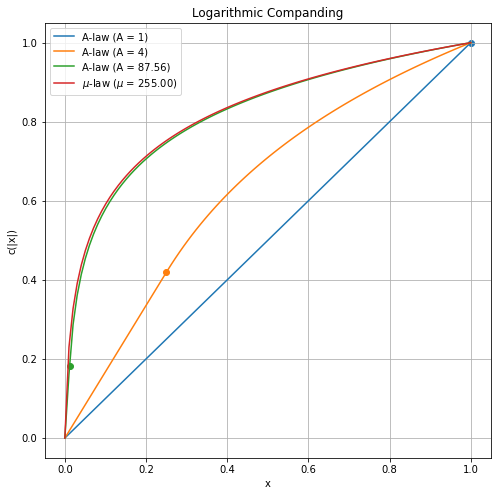

In [31]:
mu_law = lambda x, mu=255: np.log(1+mu*np.abs(x))/np.log(1+mu)
@np.vectorize
def A_law (x:float, A:float=87.56) -> float: 
    if np.abs(x) > 1/A:
        return (1 + np.log(A*np.abs(x)))/(1 + np.log(A))

    return A * np.abs(x) / (1+np.log(A))

x = np.linspace(0,1, 100)

fig, ax = plt.subplots(figsize=(8,8))

for A in [1, 4, 87.56]:
    ax.plot(x, A_law(x, A), label = 'A-law (A = {})'.format(A))
    ax.scatter(1/A, A_law(1/A, A))

for mu in [255]:
    ax.plot(x, mu_law(x, mu), label = '$\mu$-law ($\mu$ = {:.02f})'.format(mu))
ax.legend()
ax.set_xlabel('x'), ax.set_ylabel('c(|x|)')
ax.set_title('Logarithmic Companding')
ax.grid(True)

fig.savefig('./plots/logaritmic_companding.jpeg', bbox_inches='tight')

## 8.a) Working with bits

Text is normally stored as 8 bit ASCII codes (of which only the lowest seven bits are used to store the basic character set). For this exercise, you will create a lossy text codec that stores text using only five bits per character. In doing so, you will gain experience in dealing with reading/writing binary coded files.

### 1. Write a function that takes the M lowest bits from an unsigned integer and writes them starting at the Nth bit location in an array of BYTES (unsigned character variables).

### 2. Define a mapping from the basic ASCII character set onto only five bits. (Obviously, you will need to sometimes map multiple ASCII characters onto the same five-bit code. For example, you will need to map both capital and small letters onto the same code.)

### 3. Write a text encoder/decoder that allows you to read in ASCII text files (e.g., .txt files from Notepad), map the text into five bit codes, pack the coded text into arrays of BYTES, write the packed arrays into a coded file, read in your coded files, decode your coded files back into ASCII codes, and write out your decoded text file.

### 4. Test your five-bit text codec on several sample text files. Check file sizes to see what compression ratio you achieved. How readable is\ your decoded file?

### 5. Change your mapping to use two of your codes as control characters. Let one code signify that the next character is capitalized. Let the other code signify that the next character comes from a different set of mappings onto five-bit codes (i.e. include some important characters that weren't included in the basic mapping). How does this change impact compression ratio? How does this change impact readability?

In [23]:
def get_m_bits(number:float, m:int) -> str:
    binary = bin(number)[2:]
    assert m <= len(binary), 'm is bigger than "number" bits, please choose a lower m'
    
    return binary[-m:]

def insert_bits_into_bytearray(array:bytearray, bits:str, N:int) -> bytearray:
    if 'b' in bits:
        bits = bits[2:]
    bitstring = ''
    byte_list = []
    for i in array:
        bitstring += bin(i)[2:]
    new_string = bitstring[:N] + bits + bitstring[len(bits) + N:]
    for j in range(0, len(new_string), 8):
        byte = new_string[j:j+8]
        byte_list.append(int(byte, 2))
    return bytearray(byte_list)

assert get_m_bits(8, 3) == '000'
assert get_m_bits(31, 4) == '1111'

print (get_m_bits(32, 6))
ba = bytearray('hello', 'ascii') 
insert_bits_into_bytearray(ba, '1111', 27)

100000


bytearray(b'\xd1\x97f\xdf\x07')

In [26]:
char_mapping =  {
    'a': '00000', 'b': '00001', 'c': '00010',
    'd': '00011', 'e': '00100', 'f': '00101',
    'g': '00110', 'h': '00111', 'i': '01000',
    'j': '01001', 'k': '01010', 'l': '01011',
    'm': '01100', 'n': '01101', 'o': '01110',
    'p': '01111', 'q': '10000', 'r': '10001',
    's': '10010', 't': '10011', 'u': '10100',
    'v': '10101', 'w': '10110', 'x': '10111',
    'y': '11000', 'z': '11001', '1': '01011',
    '2': '11010', '3': '00100', '4': '00000',
    '5': '10010', '6': '00001', '-': '11011',
    '8': '11100', '9': '11101', '0': '01110',
    'spec': '11110', 'cap':'11111'
}

spec_chars =    {
    '.': '00000', '?': '00001', '!': '00010', 
    '&': '00011', ' ': '00100', '7': '00101',
    ',': '00110', '\r': '00111', '\n':'01000',
    '': '01001'
}

inv_map = {v: k for k, v in char_mapping.items()}
inv_spec = {v: k for k, v in spec_chars.items()}

def five_bits_encoding(string:str):
    result = ''
    capitalized = 0
    for c in string:
        if c in spec_chars.keys():
            result += char_mapping['spec']
            result += spec_chars[c]
        else:
            if c.isupper():
                capitalized = 1
                result += char_mapping['cap']
            result += char_mapping[c.lower()]
            capitalized = 0
    if len(result) % 8 != 0:
        result += '0' * (8 - (len(result) % 8))
    return result

def encode_file(source_file:str, output_file:str) -> None:
    sf = open(source_file, 'rb')
    file_string = sf.read()
    five_bits_string = five_bits_encoding(file_string.decode('ascii'))
    encoded_string = ''
    for l in range(0, len(five_bits_string), 8):
        encoded_string += chr(int(five_bits_string[l:l+8], 2))
    of = open(output_file, 'wb')
    for l in range(0, len(five_bits_string), 8):
        of.write(int(five_bits_string[l:l+8], 2).to_bytes(1, byteorder='big'))
    of.close()
    sf.close()

    return
    
def decode_file(source_file:str, output_file:str) -> None:
    with open(source_file, "rb") as sf:
        capitalized = special = eof = 0
        file_bytes = BitArray(sf.read()).bin
        decode_file = open(output_file, "wb")
        for b in range(0, len(file_bytes), 5):
            five_bits = file_bytes[b:b+5]
            if five_bits == char_mapping['cap']:
                capitalized = 1
            elif five_bits == char_mapping['spec']:
                special = 1
            else: 
                if len(five_bits) == 5:
                    if capitalized == 1 :
                        decode_file.write(bytes(inv_map[five_bits], 'ascii').upper())
                        capitalized = 0
                    elif special == 1:
                        decode_file.write(bytes(inv_spec[five_bits], 'ascii').upper())
                        special = 0
                    else:
                        decode_file.write(bytes(inv_map[file_bytes[b:b+5]], 'ascii'))
        sf.close()
        decode_file.close()

    return

In [28]:
encode_file('samples/wikipedia_spec.txt', 'samples/encoded_text.txt')

In [29]:
decode_file('samples/encoded_text.txt', 'samples/decoded_text.txt')

## 8.b) Quantization and quantization noise

In this exercise you will develop quantization routines that you will use when developing audio coders in later exercises.

### 1. Write functions that quantize floating point numbers from -1.0 up to 1.0 using 
- R-bit midtread uniform quantization; 
- R-bit midrise uniform quantization; and 
- Rs scale factor bits, Rm mantissa bits midtread floating point quantization.

### 2. Create a version of Figure 10 using 1.1 kHz sine waves sampled at 8 kHz as input.

In [309]:
def quantize_uniform(number:float, R:int, version:str='midrise') -> tuple:
    s = 0 if number >= 0 else 1
    if version == 'midrise':
        code = 2**(R-1) if abs(number) >= 1 else int(2**(R-1)*abs(number))
    else: 
        code = 2**(R-1)-1 if abs(number) >= 1 else int(((2**R-1)*abs(number)+1)/2)
    
    return s, bin(code)[2:].zfill(R-1)

def dequantize_uniform(s:int, code:str, R:int, version:str='midrise') -> float:
    sign = 1 if s == 0 else -1
    if version == 'midrise':
        return sign*(int(code, 2)+0.5)/(2**(R-1))
    
    return sign*(2*int(code, 2))/(2**R-1)

def quantize_floating_point(number, R, version='floating_point'):
    pass

number = -.35
R = 8
version = 'midtread'
s, code = quantize_uniform(number, R, version)
print (f'Quantized {number} using {version} quantization with {R} bits: [{s}][{code}]')
decoded_number = dequantize_uniform(s, code, R, version)
print (f'Dequantized [{s}][{code}] using {version} quantization with {R} bits: {decoded_number}')


Quantized -0.35 using midtread quantization with 8 bits: [1][0101101]
Dequantized [1][0101101] using midtread quantization with 8 bits: -0.35294117647058826


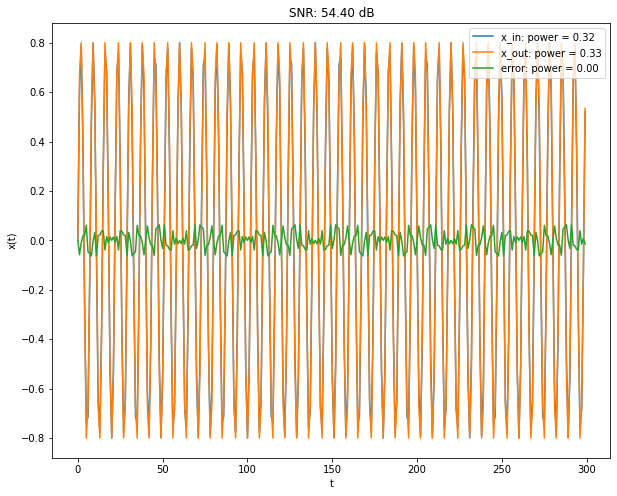

In [310]:
power = lambda x: np.mean(np.array(x)**2)

f = 1.1e3 # input signal frequency
fs = 8e3 # sampling frequency
A = .8 # senoid amplitude
R = 4 # bit resolution
N = 300 # number of samples

x_in = A*np.sin(2*np.pi*f*np.arange(N)/fs)
x_in_quantized = [quantize_uniform(x, R, version) for x in x_in]
x_out = [dequantize_uniform(s, code, R, version) for s, code in x_in_quantized]
e_quantization = [x_in[i]-x_out[i] for i in range(len(x_in))]

snr = 10*np.log(power(x_in)/power(e_quantization))

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x_in, label='x_in: power = {:.02f}'.format(power(x_in)))
ax.plot(x_out, label='x_out: power = {:.02f}'.format(power(x_out)))
ax.plot(e_quantization, label='error: power = {:.02f}'.format(power(e_quantization)))

ax.set_title('SNR: {:.02f} dB'.format(snr))
ax.set_ylabel('x(t)'), ax.set_xlabel('t') 
ax.legend()

For $x(t) = A \sin(t)$ periodic in $T$:


$$<x^2(t)> = \int_{0}^{T} A^2 sin^2(t) \cdot p(t) dt$$

Considering $t$ uniform in $[0,T]$:

$$<x^2(t)> = A^2\int_{0}^{T} sin^2(t) \cdot \frac{1}{T} dt$$
$$<x^2(t)> = \frac{A^2}{T} \cdot \Big[ t/2 - sin(2t)/4 \Big]_0^T$$
$$<x^2(t)> = \frac{A^2}{T} \cdot \Big[ T/2 - sin(2T)/4 + sin(0)/4 \Big]$$
$$<x^2(t)> = \frac{A^2}{T} \cdot \frac{T}{2}$$
$$<x^2(t)> = \frac{A^2}{2} $$

For a uniform quantizer with $R$ bits:

$$<e^2(t)> = \frac{x_{max}^2}{3\cdot 2^{2R}}$$

Therefore, considering $x_{max}^2 = 1$, the SNR results in:

$$SNR = 10 \log \frac{<x^2(t)>}{<e^2(t)}$$
$$SNR = 10 \log \frac{A^2/2>}{1/(3\cdot 2^{2R})}$$
$$SNR = 10 \log 3/2 \cdot A^2 \cdot 2^{2R}$$
$$SNR = 20 \log |A| + 20R \log 2 + 10 \log 3/2$$



In [162]:
df = pd.DataFrame(columns=['version', 'R', 'Theor. SNR', 'SNR', 'input_level'])
N = 500 # number of samples 
quantizers = ['midtread-12', 'midtread-8', 'midtread-6']

for quantizer in quantizers:
    version, R = quantizer.split('-')
    R = int(R)
    for A in np.logspace(-3, 0, num=10):
        x_in = A * np.sin(2*np.pi*f*np.arange(N)/fs)
        x_in_quantized = [quantize_uniform(x, R, version) for x in x_in]
        x_out = [dequantize_uniform(s, code, R, version) for s, code in x_in_quantized]
        e_quantization = [x_in[i]-x_out[i] for i in range(len(x_in))]

        snr = 10*np.log(power(x_in)/power(e_quantization))
        theoretical_snr = 20*np.log(A) + 20*R*np.log(2) + 20*np.log(3/2)

        df.loc[df.shape[0]] = [version, R, theoretical_snr, snr, power(x_in)]
df['analysis'] = df['version'] + '-' + df['R'].astype(str)

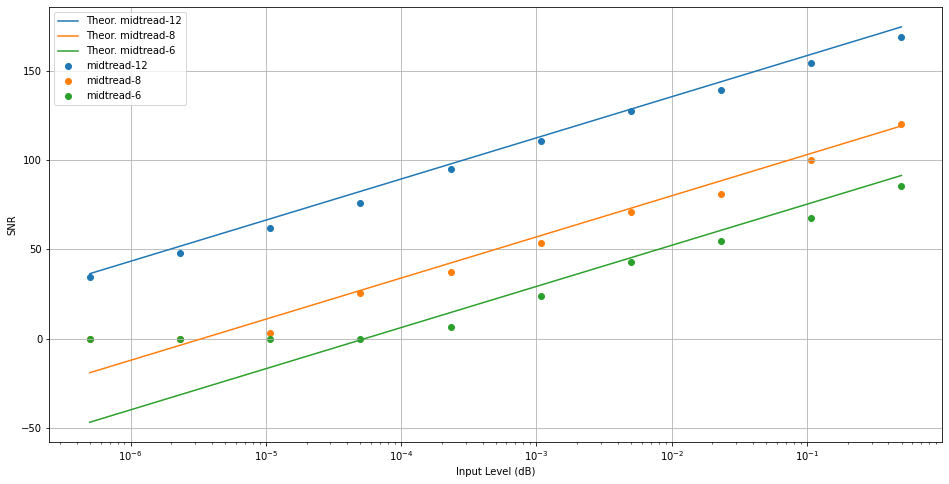

In [163]:
fig, ax = plt.subplots(figsize=(16,8))
for analysis in df.analysis.unique():
    
    df_plot = df.query('analysis == @analysis')

    R = df_plot.R.max()
    ax.scatter(df_plot.input_level, df_plot.SNR, label='{}'.format(analysis))
    ax.plot(df_plot.input_level, df_plot['Theor. SNR'], label='Theor. {}'.format(analysis))

ax.set_xscale('log')
ax.legend(loc='upper left')
ax.set_xlabel('Input Level (dB)')
ax.set_ylabel('SNR')
ax.grid(True)

fig.savefig('./plots/snr.jpeg', bbox_inches='tight')

## 8.c) A first audio coder:

In this exercise you will build a simple audio coder that allows you to test the effects of different quantization routines. You will also put in place the basic routines for reading and writing audio files that will be useful in
later exercises.

### 1. Find a 16-bit PCM audio file format that 
- 1) is well documented, 
- 2) you can play on your computer, and 
- 3) has sound samples you can
find. (For example, information about the WA V file format is readily
available on the internet. The Sound Recorder utility can be used to record and play PCM wave files.) 

Describe the file format. Get yourself a few good quality sound samples for testing codecs. Make sure you can play your samples.

### 2. Write an audio encoder/decoder that reads in 16 bit PCM audio files, dequantizes the audio samples to floating point values from -1.0 to 1.0, quantizes the samples using the quantization functions you prepared for the prior exercise, packs the quantized samples into arrays of BYTES, writes the results into a coded file format you define, reads in your coded file, converts your data back into 16 bit PCM codes, and writes out your decoded audio data into an audio file you can play. Verify that your coder is bug-free by making sure that files coded using 16-bit midtread uniform quantization do not sound
degraded when decoded.

### 3. Test your codec on some sound samples using 
- 1) four-bit midtread uniform quantization, 
- 2) four-bit midrise uniform quantization, 
- 3) eight-bit midtread uniform quantization, and 
- 4) three scale bits, five mantissa bits midtread floating point quantization. 

What compression ratios do you get? Describe the quantization noise you hear.

### 4. Estimate symbol probabilities for each of the 15 codes used in four-bit midtread uniform quantization using your sound samples. Use these probabilities to define a set of Huffman codes for your four-bit quantization codes. Modify your codec to read/write the coded file format using these Huffman codes when encoding using four-bit midtread uniform quantization. How much do the Huffman codes improve the compression on your sound samples?

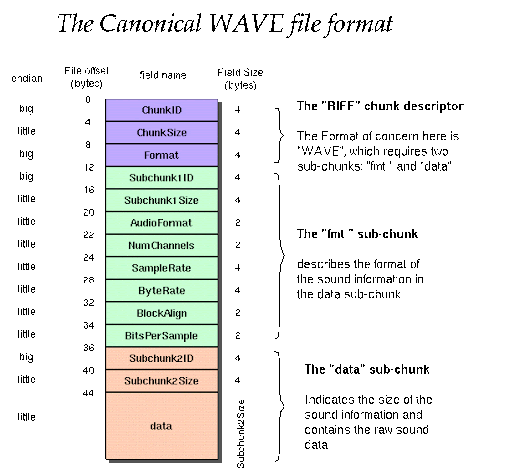

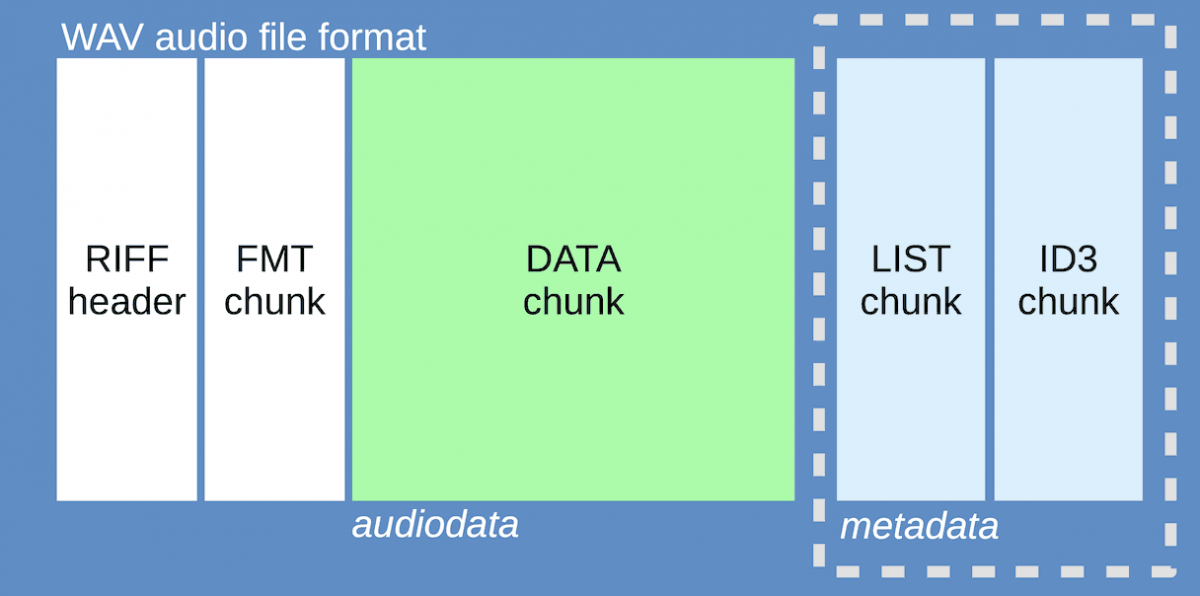



In [1]:
def code_uniform_midrise(number,R):
    if number>=0:
        signal=1
    else:
        signal=-1
    if abs(number)>=1:
        output=2**(R-1)-1
    else:
        output=int(2**(R-1)*abs(number))
    
    return signal*output


def code_uniform_midtread(number,R):
    if number>=0:
        signal=1
    else:
        signal=-1
    if abs(number)>=1:
        output=2**(R-1)-1
    else:
        output=int( ((2**R-1)*abs(number) + 1)/2 )
    
    return signal*output

def decode_uniform_midrise(code,R):
    signal = 2*int(code&(2**(R-1))==0) - 1 
    number_abs = (abs(code)+1/2)/(2**(R-1))
    return signal*number_abs

def decode_uniform_midtread(code,R):
    signal = 2*int(code&2**(R-1)==0) - 1 
    number_abs = 2*abs(code)/(2**R-1)
    return signal*number_abs

def countZeros(x,R):
     
    # Keep shifting x by one until
    # leftmost bit does not become 1.
    res=0
    if x==0:
        return R
    while ((x & (1 << (R - 1))) == 0):
        x = (x << 1)
        res += 1
 
    return res

  
def code_floating_point(number,coder,R_s,R_m):
    R = 2**(R_s) -1 + R_m
    if coder == 'midrise':
        code = code_uniform_midrise(number,R)
    elif coder == 'midtread':
        code = code_uniform_midtread(number,R)
    else:
        raise ValueError('please choose midrise or midtread as coder')
    s = int(code&(2**(R-1))!=0)
    num_zeros = countZeros(abs(code),R-1)
    if num_zeros<= 2**R_s-1:
        scale=2**R_s-1-num_zeros
    else:
        scale=0
    if scale==0:
        mantissa= s<<(R_m-1)
        mantissa+= abs(code)
    else:
        mantissa= s<<(R_m-1)
        shift = (R-num_zeros- R_m - 1)
        mask = (2**(R_m-1)-1)<< shift
        mantissa+= (mask&abs(code)) >>shift

    return scale,mantissa


def decode_floating_point(scale,mantissa,decoder,R_s,R_m):
    R = 2**(R_s) -1 + R_m
    init_shift = R - 2**R_s - 1 
    s = int(mantissa&(2**(R_m-1))!=0)
    output = 1
    output = output<<(2**R_s-1-scale) # putting zeros from scale
    total_shift = 2**R_s-1-scale

    if scale==0:
        mask = 2**(R_m-1) - 1
        output= (output<<(R_m-1)) + (mantissa&mask)
        total_shift += (R_m-1)
    else:
        output = (output<<1) + 1
        mask = 2**(R_m-1) - 1
        output= (output<<R_m-1)
        output = output + (mantissa&mask)
        total_shift += R_m
  
  
    if scale>1:
        output = (output<<1)+1
        shift = R - (len(bin(output)) -2)
        output = output<<shift
        total_shift +=shift + 1
  


    abs_out = output&(2**(total_shift)-1)
    signal = 2*int(not s) - 1


    R_bit_num = signal*abs_out

    if decoder == 'midrise':
        number = decode_uniform_midrise(R_bit_num,R)
    elif decoder == 'midtread':
        number = decode_uniform_midtread(R_bit_num,R)
    else:
        raise ValueError('please choose midrise or midtread as decoder')

    return number


In [51]:
import struct
import io

def read_wav_data_new(filename):
    with io.open(filename, 'rb') as fh:
        # Do stuff with byte.
        riff, size, fformat = struct.unpack('<4sI4s', fh.read(12))
        print("Riff: %s, Chunk Size: %i, format: %s" % (riff, size, fformat))
        #Read header
        fmt_header = fh.read(8)
        subchunkid, subchunksize = struct.unpack('<4sI', fmt_header)
        if (subchunkid == b'fmt '):
            if (subchunksize == 16):
                fmt_data = fh.read(16)
            elif (subchunksize == 18):
                fmt_data = fh.read(18)
            elif (subchunksize == 40):
                fmt_data = fh.read(40)
            else:
                raise ValueError('Invalid Format Chunk size (16, 18 or 40)') 

        chunkOffset = fh.tell()
        print(chunkOffset,size)
        subchunks = []
        while (chunkOffset < size):
            fh.seek(chunkOffset)
            subchunk2id, subchunk2size = struct.unpack('<4sI', fh.read(8))
            chunk_header= struct.pack('<4sI', subchunk2id, subchunk2size)
          
            if (subchunk2id == b'data'):
                print("Found data")
                curr_byte=chunkOffset
                data_list=[]
                data_chunkid = subchunk2id
                data_chunk_size = subchunk2size
                while (curr_byte< subchunk2size+chunkOffset):
                    curr_byte+=2
                    byte1 = struct.unpack('<h', fh.read(2))
                    data_list.append(byte1[0]/2**(15)) # lendo e normalizando
            else:
                subchunk_data = fh.read(subchunk2size)
                subchunks.append((subchunk2id,subchunk2size,subchunk_data))
            chunkOffset = chunkOffset + subchunk2size + 8
            
        params = riff, size, fformat,fmt_header, fmt_data, data_chunkid, data_chunk_size, subchunks
    return params,data_list

In [53]:
params,data_list = read_wav_data_new('samples/fala.wav')

Riff: b'RIFF', Chunk Size: 126040, format: b'WAVE'
38 126040
Found data


In [54]:
def write_wav(filename,params,data):
    riff, size, fformat,fmt_header, fmt_data, data_chunkid, data_chunk_size, subchunks = params
    header = struct.pack('<4sI4s',riff, size, fformat)
    header+=fmt_header
    header+=fmt_data
    header+=struct.pack('<4sI', data_chunkid, data_chunk_size)
    data_string = b''
  
    for item in data:
        data_string+= struct.pack('<h',int(item*(2**15))) 
    output=header+data_string
    for subchunk in subchunks:
        (subchunkid,subchunksize,subchunk_data) = subchunk
        output+=struct.pack('<4sI', subchunkid, subchunksize)
        output+=subchunk_data
    with open(filename,'wb') as f:
        f.write(output)

write_wav('samples/output.wav',params,data_list)

In [55]:
import filecmp
filecmp.cmp('samples/fala.wav','samples/output.wav',shallow=False)

True

In [26]:
!pip install bitstring
from bitstring import ConstBitStream
from bitstring import Bits
def bitstring_to_bytes(s):
    return int(s, 2).to_bytes((len(s) + 7) // 8, byteorder='big')


def code_decode_wav_new(data_list,n_bits,coder,code_filename,output_filename,wav_params,**kwargs):
    short_bytelist = ''
    if coder == 'midtread':
        coded_list = [code_uniform_midtread(x,n_bits) for x in data_list]    
    elif coder == 'midrise':
        coded_list = [code_uniform_midrise(x,n_bits) for x in data_list]
    
    elif coder == 'fp_midtread':
        R_s,R_m = kwargs['R_s'],kwargs['R_m']
        n_bits = R_s + R_m
        coded_list = [code_floating_point(x,'midtread',R_s,R_m) for x in data_list]

    if coder =='midtread' or coder=='midrise':
        for item in coded_list:
            str_bits = Bits(int=item, length=n_bits).bin
            short_bytelist+=str_bits
    else:
        for scale,mantissa in coded_list:
            aux = scale<<R_m
            aux = aux + mantissa
            str_bits = Bits(uint=aux, length=n_bits).bin
            short_bytelist+=str_bits
    
  
    coded_data = bitstring_to_bytes(short_bytelist)
    with io.open(code_filename, 'wb') as fh:
        fh.write(coded_data) 

    b = ConstBitStream(filename=code_filename)

    read_data = []
    curr_bit=0
    if coder =='midtread' or coder=='midrise':
        while (curr_bit<b.length):
            code = b.read('int:{}'.format(n_bits))
            curr_bit += n_bits
            read_data.append(code)
    else:
        mask_scale = (2**R_s - 1)<<R_m
        mask_mantissa = 2**R_m-1
        while (curr_bit<b.length):
            code = b.read('uint:{}'.format(n_bits))
            
            scale = (code&mask_scale)>>R_m
            mask_mantissa = 2**R_m-1
            mantissa=code&mask_mantissa
            read_data.append((scale,mantissa))
            curr_bit += n_bits


    bytelist = []
    for item in read_data:
        if coder == 'midtread':
            x = decode_uniform_midtread(item,n_bits)
        elif coder == 'midrise':
            x = decode_uniform_midrise(item,n_bits)
        elif coder == 'fp_midtread':
            scale,mantissa = item
            try:
                x = decode_floating_point(scale,mantissa,'midtread',R_s=R_s,R_m=R_m)
            except:
                print(scale,mantissa)
        
        x = code_uniform_midtread(x,16)
        bytelist.append(x/(2**15))
    
    write_wav(output_filename,wav_params,bytelist)
    
    return data_list,read_data

In [105]:
n_bits = 8
input_filename ='samples/fala.wav'
bin_filename='samples/fala_fp_35.bin'
output_filename='samples/fala_fp_35.wav'

params,data_list = read_wav_data_new(input_filename)
data_list, read_data = code_decode_wav_new(data_list,n_bits,'fp_midtread',bin_filename,output_filename,params, R_s=3,R_m=5)

Riff: b'RIFF', Chunk Size: 126040, format: b'WAVE'
38 126040
Found data


In [73]:
def calc_freq(data):
    freq_dict = {}
    for entry in data:
        if entry in freq_dict:
            freq_dict[entry] +=1
        else:
            freq_dict[entry] = 1
    
    return freq_dict

In [74]:
freq_dict = calc_freq(read_data)
freq_dict

{0: 44659,
 1: 5409,
 -1: 7121,
 2: 2483,
 -2: 2390,
 3: 662,
 4: 80,
 -3: 163,
 5: 6,
 -4: 28,
 -5: 1}

In [75]:
class node:
    def __init__(self, freq, symbol, left=None, right=None):
        # frequency of symbol
        self.freq = freq
 
        # symbol name (character)
        self.symbol = symbol
 
        # node left of current node
        self.left = left
 
        # node right of current node
        self.right = right
 
        # tree direction (0/1)
        self.huff = ''
 
 # utility function to print huffman
# codes for all symbols in the newly
# created Huffman tree
 
huff_dict = {}
def printNodes(node, val=''):
    # huffman code for current node
    newVal = val + str(node.huff)
 
    # if node is not an edge node
    # then traverse inside it
    if(node.left):
        printNodes(node.left, newVal)
    if(node.right):
        printNodes(node.right, newVal)
 
        # if node is edge node then
        # display its huffman code
    if(not node.left and not node.right):
        print(f"{node.symbol} -> {newVal}")
        if len(newVal)>0:
            huff_dict[node.symbol] = newVal


# list containing unused nodes
nodes = []
 
# converting ccharacters and frequencies
# into huffman tree nodes
for key,value in freq_dict.items():
    nodes.append(node(value, key))
    

while len(nodes) > 1:
    # sort all the nodes in ascending order
    # based on theri frequency
    nodes = sorted(nodes, key=lambda x: x.freq)
 
    # pick 2 smallest nodes
    left = nodes[0]
    right = nodes[1]
 
    # assign directional value to these nodes
    left.huff = 0
    right.huff = 1
 
    # combine the 2 smallest nodes to create
    # new node as their parent
    newNode = node(left.freq+right.freq, left.symbol+right.symbol, left, right)
 
    # remove the 2 nodes and add their
    # parent as new node among others
    nodes.remove(left)
    nodes.remove(right)
    nodes.append(newNode)

# Huffman Tree is ready!
printNodes(nodes[0])

-1 -> 00
1 -> 010
2 -> 0110
-5 -> 0111000000
5 -> 0111000001
-4 -> 011100001
4 -> 01110001
-3 -> 0111001
3 -> 011101
-2 -> 01111
0 -> 1


In [76]:
huff_inv = {v: k for k, v in huff_dict.items()}
huff_inv

{'00': -1,
 '010': 1,
 '0110': 2,
 '0111000000': -5,
 '0111000001': 5,
 '011100001': -4,
 '01110001': 4,
 '0111001': -3,
 '011101': 3,
 '01111': -2,
 '1': 0}

In [77]:
from bitstring import BitArray
b=''
coded_list = [code_uniform_midtread(x,4) for x in data_list]
for item in coded_list:
    code = huff_dict[item]
    b+=code

if len(b)%8 !=0:
    b = b + '1'*(8 - len(b)%8)

In [78]:
coded_data = bitstring_to_bytes(b)
with io.open('samples/coded_huffman.bin', 'wb') as fh:
    fh.write(coded_data)

In [79]:
b = ConstBitStream(filename='samples/coded_huffman.bin')

huff_read_data = []
curr_bit=0
while (curr_bit<b.length):
    code = ''
    while(code not in huff_inv):
        code+=b.read(1).bin
        curr_bit+=1
    code = huff_inv[code]
  
    huff_read_data.append(code)

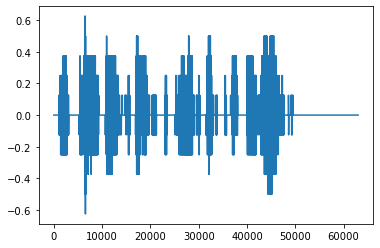

In [91]:
plt.plot(np.array(huff_read_data)/(2**(3)))

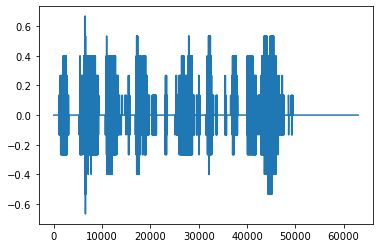

In [96]:
decoded_data = [decode_uniform_midtread(x,n_bits) for x in read_data]
plt.plot(np.array(decoded_data))

In [100]:
huff_read_data = [x/(2**3) for x in huff_read_data]
write_wav('samples/huff.wav',params,huff_read_data)